<a href="https://colab.research.google.com/github/tejasramramesh/Cryptocurrency-prediction-/blob/main/TensorFlow/Tejas/Deep_Learning_HW4_Q4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Home Work 4 

References:



#GPU Check

In [97]:
#Path: TensorFlow/Tejas/
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [98]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.9.2


In [99]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.4070130219997736
GPU (s):
0.03821819999984655
GPU speedup over CPU: 10x


#Dependencies

In [100]:
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
import keras.utils
from keras import utils as np_utils
from keras.models import Sequential
from keras.layers import  Dense, Dropout, Activation, Flatten
from librosa.core import stft,istft
import soundfile as sf
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa
%matplotlib inline

##Load Data Set

We load X_train and X_test from pkl files respectively.



1.   But we have to make an empty array of (500,1) for y_train and (200,1) for y_test as they are labels of 1 and 0.
2.   1 is label for positive batching (audio signal pairs are utterances of same speaker)

1.   0 is for negative batching ( audio signal pairs of different speakers)







In [101]:
#Dependencies for Loading data 

import gzip
import pickle
import random
from itertools import combinations,product

In [102]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
with open('/content/drive/MyDrive/ENGR-E-533 /DATA/HW4/Q4 Speaker Recognition/hw4_trs.pkl', 'rb') as f:
    X_train = pickle.load(f)

In [104]:
print(X_train.shape)

(500, 16180)


In [105]:
y_train = np.zeros((500,1))
index=0
for i in range(0,50):
    for j in range(0,10):
        y_train[index]=i
        index+=1
print(y_train.shape)

(500, 1)


In [106]:
with open('/content/drive/MyDrive/ENGR-E-533 /DATA/HW4/Q4 Speaker Recognition/hw4_tes.pkl', 'rb') as f:
    X_test = pickle.load(f)

In [107]:
print(X_test.shape)

(200, 22631)


In [108]:
y_test = np.zeros((200,1))
idx=0
for i in range(0,20):
    for j in range(0,10):
        y_test[idx]=i
        idx+=1
print(y_test.shape)

(200, 1)


In [109]:
X_train[:10]

array([[ 4.12784029e-05,  2.06392011e-04,  0.00000000e+00, ...,
        -9.50228795e-02, -8.75514895e-02, -7.98324272e-02],
       [ 0.00000000e+00,  2.19764952e-05,  8.79059808e-05, ...,
         1.13178967e-02,  1.05047654e-02,  1.43506527e-02],
       [ 1.85077588e-04,  1.48062070e-04,  1.11046553e-04, ...,
        -8.95775482e-03, -1.47321764e-02, -2.06546579e-02],
       ...,
       [ 1.53322384e-04,  1.53322384e-04,  1.53322384e-04, ...,
         9.65930894e-03, -1.31857244e-03, -1.06099080e-02],
       [ 1.14315364e-04, -1.14315364e-04,  7.62102427e-05, ...,
        -1.21555338e-02, -4.95366578e-04,  8.57365225e-03],
       [ 3.40873594e-05,  2.04524142e-04,  6.81747188e-05, ...,
        -3.63371223e-02, -7.14471042e-02, -9.41492841e-02]], dtype=float32)

In [110]:
X_test[:10]

array([[ 1.27267512e-03, -1.81810741e-04,  2.72716105e-04, ...,
        -3.63621465e-03, -3.45440372e-03, -4.18164674e-03],
       [-2.33645900e-04,  2.33645900e-04,  0.00000000e+00, ...,
        -7.00937724e-03, -7.63243251e-03, -9.57948156e-03],
       [ 1.45140267e-03, -1.93520362e-04,  2.90280528e-04, ...,
        -2.32224423e-03, -2.99956556e-03, -2.61252490e-03],
       ...,
       [-1.09347195e-04, -1.09347195e-04,  0.00000000e+00, ...,
         1.64020795e-03,  1.20281905e-03,  1.20281905e-03],
       [ 8.59142674e-05,  0.00000000e+00,  8.59142674e-05, ...,
        -1.71828535e-04,  1.11688545e-03,  8.59142689e-04],
       [ 8.90608819e-04,  0.00000000e+00,  2.54459679e-04, ...,
         1.20868338e-02, -1.41225122e-02,  1.90844748e-03]], dtype=float32)

**Training Matrix :** (Row:Speaker Number,audio signal)
Each speaker has 10 signals (Utterances)


*   We have 50 speakers hence 500 rows  ( 50 unique speakers with 10 utterances each)
*   Train Speakers have 16180 features per sample.


**Test Matrix:** (Row:Speaker Number,audio signal)
Each speaker has 10 signals(Utterances)


*   We have 20 speakers hence 200 rows  ( 20 unique speakers with 10 utterances each)
*   But Test Speakers have more features in the signal: 22631 ( More Rich in data )



Resource for random sampling : https://pynative.com/python-random-sample/







#STFT of X_train and X_test

In [111]:
L_utterance = 45

In [112]:
X_train_stft = np.zeros(shape=(500,L_utterance,513))
for i in range(X_train.shape[0]):
    X_data = X_train[i,:]
    X_complex = librosa.stft(X_data, n_fft=1024, hop_length=512)
    X = np.abs(X_complex).T
    X_train_stft[i,:,:] = np.pad(X,((0,13),(0,0)), 'constant') # pas top = 0 , bottom = 13, left = 0 and right = 0 
    #pads only bottom of the array because 16810 / 513 = 32 and test data has 45
print(X_train_stft.shape)

(500, 45, 513)


In [113]:
X_train_stft[1]

array([[0.02651631, 0.01149094, 0.00238631, ..., 0.00408146, 0.00277443,
        0.00204568],
       [0.03155294, 0.017131  , 0.00196619, ..., 0.00112135, 0.00039424,
        0.00010901],
       [0.02640126, 0.01126922, 0.00266385, ..., 0.00064208, 0.00035836,
        0.0001147 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [114]:
X_train_stft[1].shape

(45, 513)

In [115]:
X_test_stft = np.zeros(shape=(200,45,513))
for i in range(X_test.shape[0]):
    X_data = X_test[i,:]
    X_complex = librosa.stft(X_data, n_fft=1024, hop_length=512)
    X = np.abs(X_complex).T
    X_test_stft[i,:,:] = X
print(X_test_stft.shape)

(200, 45, 513)


#Pairing without indexing

Encountering an issue with getting data of other speakers in pairs.

Hence i follow keras documentation code and use indexing

Error at line :   other_speaker_data =X_train[sample for sample in range(500) if sample not in speaker_data_index ]


Maybe I can set X_train[:start] + X_train[end:]


But after indexing code cause that is a sure shot solution

In [116]:
# unique_speaker = 50
# speaker_index = 0
# L_utterance = 45  
# pair = []      
# labels =[]
# for speaker in range(unique_speaker): # used range so that max value of speaker_index will be 49
#   speaker_data = X_train[speaker * 10 : (speaker+1) * 10 ]
#   speaker_data_index = np.arange(speaker*10,(speaker+1) * 10,1)
#   print(speaker_data_index)
#   other_speaker_data =X_train[sample for sample in range(500) if sample not in speaker_data_index ]
#   #print(len(speaker_data))
#   #speaker_index = speaker_index + 1

#   pos_pairs = random.sample(list(combinations(speaker_data,2)),L_utterance)
#   #print(pos_pairs)
#   for pairs in pos_pairs:
#     x1 = pairs[0]
#     x2 = pairs[1]
#     pair += [[x1,x2]]
#     labels += [1]
    #print(pair[0][:])
    #print(labels)

  #neg_pairs = random.sample(list(combinations(other_speaker_data,speaker_data)))
  #neg_pairs = random.sample(list(product(speaker_data,other_speaker_data)),L_utterance)

    






##Pairing with indexing



In [117]:
L_utterance = 45

In [132]:
#Code follows structure given in https://keras.io/examples/vision/siamese_contrastive/

L_utterance = 45
y_train = np.array(y_train)
X_index = np.arange(0,len(y_train)).reshape(-1,1)
unique_speaker = np.unique(y_train)
pairs = []
labels =[]

for speaker in unique_speaker:
  speaker_index = X_index[np.where(y_train==speaker)]
  other_speaker_index = X_index[np.where(y_train!=speaker)]

  L_pos_list = list(combinations(speaker_index,2))
  L_pos_pairs = random.sample( L_pos_list,L_utterance)
  for pair in L_pos_pairs:
    sample1 = X_train_stft[pair[0],:,:]
    sample2 = X_train_stft[pair[1],:,:]
    pairs = pairs + [[sample1,sample2]]
    labels = labels + [0]

  L_neg_pairs = list(product(speaker_index,other_speaker_index))
  L_neg_pairs = random.sample( L_neg_pairs,L_utterance)
  for pair in L_neg_pairs:
    neg_sample1 = X_train_stft[pair[0],:,:]
    neg_sample2 = X_train_stft[pair[1],:,:]
    pairs = pairs + [[neg_sample1,neg_sample2]]
    labels = labels + [1]

pair = np.asarray(pairs)
label = np.asarray(labels).astype("float32")

In [119]:
pair.shape

(4500, 2, 45, 513)

In [120]:
pair

array([[[[2.72731502e-02, 1.32017657e-02, 1.63700338e-03, ...,
          4.50400868e-04, 3.24209133e-04, 6.35247619e-04],
         [2.64394600e-02, 1.06862374e-02, 5.14851045e-03, ...,
          7.70059996e-04, 1.08805101e-03, 1.08713307e-03],
         [4.64950614e-02, 2.51820087e-02, 4.07007663e-03, ...,
          1.94051405e-04, 3.69657733e-04, 2.23720839e-04],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[4.00531106e-03, 7.33557390e-03, 1.29556819e-03, ...,
          1.01687772e-04, 1.24751125e-03, 1.16328849e-03],
         [5.43834046e-02, 3.73508334e-02, 7.40372762e-03, ...,
          7.69626757e-04, 1.11309427e-03, 5.99727791e-04],
        

In [121]:
label.shape

(4500,)

pair.shape = (4500, 2, 45, 513)

We have 4500 pairs
Each pair contains 2 samples
each sample shape is (45,513)

L_utterance is 45 hence we have a 2L batch of 90 size


50 of such speakers hence we have 90*50 = 4500 pairs

In [122]:
#Code follows structure given in https://keras.io/examples/vision/siamese_contrastive/

L_utterance = 45
y_train = np.array(y_test)
X_index = np.arange(0,len(y_test)).reshape(-1,1)
unique_speaker = np.unique(y_test)
testpairs = []
testlabels =[]

for speaker in unique_speaker:
  speaker_index = X_index[np.where(y_train==speaker)]
  other_speaker_index = X_index[np.where(y_train!=speaker)]

  L_pos_list = list(combinations(speaker_index,2))
  L_pos_pairs = random.sample( L_pos_list,L_utterance)
  for pair in L_pos_pairs:
    sample1 = X_test_stft[pair[0],:,:]
    sample2 = X_test_stft[pair[1],:,:]
    testpairs = testpairs + [[sample1,sample2]]
    testlabels = testlabels + [0]

  L_neg_pairs = list(product(speaker_index,other_speaker_index))
  L_neg_pairs = random.sample( L_neg_pairs,L_utterance)
  for pair in L_neg_pairs:
    neg_sample1 = X_test_stft[pair[0],:,:]
    neg_sample2 = X_test_stft[pair[1],:,:]
    testpairs = testpairs + [[neg_sample1,neg_sample2]]
    testlabels = testlabels + [1]

testpair = np.asarray(testpairs)
testlabel = np.asarray(testlabels).astype("float32")

In [123]:
testpair.shape

(1800, 2, 45, 513)

In [124]:
testpair[:,1]

array([[[1.07173719e-01, 6.33505881e-02, 9.04773362e-03, ...,
         2.68495409e-03, 5.53215214e-04, 2.78911041e-03],
        [4.25813235e-02, 1.61579978e-02, 9.68609191e-03, ...,
         5.70541015e-03, 5.15174866e-03, 3.58864060e-03],
        [3.36469673e-02, 1.67639926e-02, 4.80965991e-03, ...,
         2.98305531e-03, 4.10038140e-03, 3.82755068e-03],
        ...,
        [6.32405980e-03, 1.57089196e-02, 2.91497037e-02, ...,
         1.69631429e-02, 1.76991969e-02, 1.55852716e-02],
        [2.21883804e-02, 1.27629526e-02, 1.88634545e-02, ...,
         6.26697298e-03, 5.77514293e-03, 4.50461404e-03],
        [1.83873829e-02, 2.11114455e-02, 2.52998974e-02, ...,
         4.32973215e-03, 6.50515733e-03, 7.85188284e-03]],

       [[3.00593022e-02, 1.74165703e-02, 4.55747591e-03, ...,
         2.99935183e-03, 5.07844263e-04, 2.58241897e-03],
        [3.81037756e-03, 7.66390562e-03, 1.18152509e-02, ...,
         1.90717995e-03, 8.72110249e-04, 1.18182325e-04],
        [4.22144122e-02, 

In [125]:
testlabel.shape

(1800,)

In [126]:
type(testpair)

numpy.ndarray

pair.shape = (4500, 2, 45, 513)

We have 4500 pairs
Each pair contains 2 samples
each sample shape is (45,513)

L_utterance is 45 hence we have a 2L batch of 90 size


50 of such speakers hence we have 90*50 = 4500 pairs

In [192]:
#Reference : https://keras.io/examples/vision/siamese_contrastive/
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


In [215]:
#Ref: #Reference : https://keras.io/examples/vision/siamese_contrastive/ 
#and https://towardsdatascience.com/siamese-networks-introduction-and-implementation-2140e3443dee


input = layers.Input(shape=(45,513))
x = tf.keras.layers.GRU(513, return_sequences=True,dropout=0.3 ,name = "layer1")(input),
# x = tf.keras.layers.GRU(513, return_sequences=True,dropout=0.3, name = "layer2")(x[0]),
x = tf.keras.layers.GRU(513, return_sequences=False,dropout=0.3 , name = "layer3")(x[0]),
x = tf.keras.layers.Dense(128,activation = 'relu' , name = "Denselayer2")(x[0]),
x = tf.keras.layers.Dense(32,activation = 'relu', name = "Denselayer3")(x[0])
# x = tf.keras.layers.Dense(16,activation = 'relu' , name = "Denselayer4")(x[0])

embedding_network = tf.keras.Model(input, x)

ip1 = layers.Input((45,513))
ip2 = layers.Input((45,513))

left_model = embedding_network(ip1)
right_model = embedding_network(ip2)

x2 = tf.keras.layers.Lambda(euclidean_distance)([left_model, right_model])
output = tf.keras.layers.Dense(1, activation="sigmoid")(x2)
siamesemodel = tf.keras.Model(inputs=[ip1, ip2], outputs=output)

In [216]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.
    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [217]:
siamesemodel.compile(loss=loss(margin=1), optimizer="adam", metrics=["accuracy"])
siamesemodel.summary()

Model: "model_60"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_97 (InputLayer)          [(None, 45, 513)]    0           []                               
                                                                                                  
 input_98 (InputLayer)          [(None, 45, 513)]    0           []                               
                                                                                                  
 model_59 (Functional)          (None, 32)           3234104     ['input_97[0][0]',               
                                                                  'input_98[0][0]']               
                                                                                                  
 lambda_31 (Lambda)             (None, 1)            0           ['model_59[0][0]',        

In [218]:
history = siamesemodel.fit(
    [pair[:,0], pair[:,1]],
    label,
    validation_data=([testpair[:,0],testpair[:,1]],testlabel),
    batch_size=60,
    epochs=40
)

Epoch 1/40
30/30 [==============================] - 7s 88ms/step - loss: 0.2504 - accuracy: 0.5000 - val_loss: 0.2688 - val_accuracy: 0.5000
Epoch 2/40
30/30 [==============================] - 1s 35ms/step - loss: 0.2476 - accuracy: 0.5006 - val_loss: 0.2997 - val_accuracy: 0.5000
Epoch 3/40
30/30 [==============================] - 1s 35ms/step - loss: 0.2243 - accuracy: 0.5294 - val_loss: 0.2662 - val_accuracy: 0.5000
Epoch 4/40
30/30 [==============================] - 1s 35ms/step - loss: 0.2109 - accuracy: 0.5778 - val_loss: 0.2198 - val_accuracy: 0.5289
Epoch 5/40
30/30 [==============================] - 1s 35ms/step - loss: 0.2068 - accuracy: 0.6522 - val_loss: 0.2629 - val_accuracy: 0.5172
Epoch 6/40
30/30 [==============================] - 1s 35ms/step - loss: 0.2233 - accuracy: 0.6539 - val_loss: 0.2342 - val_accuracy: 0.5528
Epoch 7/40
30/30 [==============================] - 1s 35ms/step - loss: 0.2363 - accuracy: 0.5933 - val_loss: 0.2496 - val_accuracy: 0.5072
Epoch 8/40
30

In [219]:
history1 = siamesemodel.evaluate([testpair[:,0],testpair[:,1]],testlabel)

57/57 [==============================] - 2s 11ms/step - loss: 0.1942 - accuracy: 0.7028


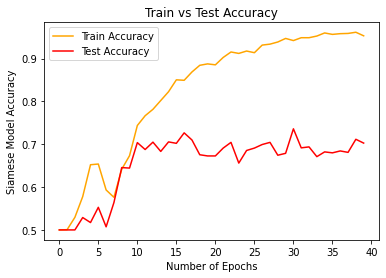

In [223]:
plt.plot(history.history["accuracy"],color='orange')
plt.plot(history.history["val_accuracy"],color='red')
plt.legend(["Train Accuracy", "Test Accuracy"], loc="upper left")
plt.title("Train vs Test Accuracy")
plt.ylabel("Siamese Model Accuracy")
plt.xlabel("Number of Epochs")
plt.show()